              precision    recall  f1-score   support

           0       0.82      0.56      0.66      2839
           1       0.38      0.68      0.48      1108

    accuracy                           0.59      3947
   macro avg       0.60      0.62      0.57      3947
weighted avg       0.69      0.59      0.61      3947

Precision: 0.8169665809768637
Recall: 0.5597041211694258
F1 Score: 0.6642976588628763


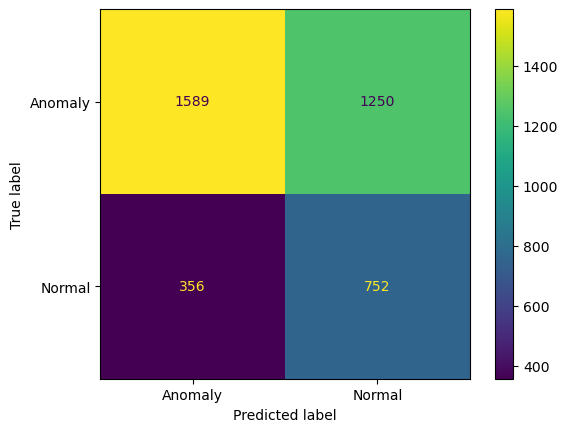

In [2]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

def hybrid_anomaly_detection():
    
    
    data = pd.read_csv('energydata.csv')
    
    data = data.drop('date', axis=1)
    
    X = data.drop('Windspeed', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['Windspeed']
    
    #convert all the values in the columns into numeric
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')

    data.dropna(axis=0, inplace=True)
    
#     #Scatter plot
#     sns.pairplot(data, kind='scatter')
#     plt.title('Scatter Plot')
#     plt.show()
    
    
    y = np.where(y_cont > 5, 1, 0)  # Define `threshold` based on the dataset
    
        
    # Select top k features; you might adjust k based on your dataset
    selector = SelectKBest(f_classif, k=10)
    X_selected = selector.fit_transform(X, y)
    
    
    
    
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    
    # Train SVM on the training data
    svm = SVC(kernel='rbf', gamma='scale', class_weight='balanced', random_state=42)
    svm.fit(X_train, y_train)
    svm_predictions_train = svm.predict(X_train)
    svm_predictions_test = svm.predict(X_test)

    # Enhance the dataset with SVM outcomes
    X_train_enhanced = np.hstack((X_train, svm_predictions_train.reshape(-1, 1)))
    X_test_enhanced = np.hstack((X_test, svm_predictions_test.reshape(-1, 1)))

    # Filter only rows SVM detected as normal (label '1')
    normal_indices_train = svm_predictions_train == 1
    X_train_filtered = X_train_enhanced[normal_indices_train]
    y_train_filtered = y_train[normal_indices_train]

    # Train Isolation Forest on filtered normal data
    iso_forest = IsolationForest(random_state=42)
    iso_forest.fit(X_train_filtered, y_train_filtered)
    if_predictions = iso_forest.predict(X_test_enhanced)
    if_predictions = np.where(if_predictions == 1, 1, 0)  # Align with binary labels

    # Evaluate the model
    precision = precision_score(y_test, if_predictions, pos_label=0)  # Anomalies labeled as '0'
    recall = recall_score(y_test, if_predictions, pos_label=0)  # Anomalies labeled as '0'
    f1 = f1_score(y_test, if_predictions, pos_label=0)  # Anomalies labeled as '0'

    # Output the evaluation metrics
    
    print(classification_report(y_test, if_predictions))
    
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, if_predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()


# Example usage
# Assuming X and y are your dataset's features and labels respectively (with '1' as normal, '-1' as anomaly)
hybrid_anomaly_detection()
